# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
#!gdown https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL


In [2]:
#!unzip Project_data.zip

In [3]:
import numpy as np
import os
import cv2
from cv2 import imread
import matplotlib.pyplot as plt
#from scipy.misc import imread, imresize
import datetime
import os
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

from keras.models import Model, load_model, Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalMaxPool3D
# from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from keras import optimizers
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.layers import concatenate, add
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
#tf.device('/cpu:0')

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# reusable functions
def resize(input_image,threshold=False):
   # gray = cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY)
   resized = cv2.resize(input_image, dsize=(120, 120), interpolation=cv2.INTER_CUBIC)
   input_image = img_to_array(resized)
   return input_image

def normalize_image(input_image):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   return input_image

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


In [6]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size
# print(len(train_doc))
global number_of_sequences
number_of_sequences = 30 #len(train_doc)
# batch size should be large enough to include all the train data.
# GPU might not be able to handle all the train data, in that case we will have to reduce the batch data.
# assignment - 663 folder approx 1.5 GB

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30)) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = 120
    z = 120
    # 30 images per folder, might not want to use all of them.
    # sampling 15-20 images should be good.
    # 30 might lead to memory issues
    while True:
        t = np.random.permutation(folder_list)
        num_batches = number_of_sequences//batch_size # calculate the number of batches
        print(num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image)
                    image = normalize_image(image)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (number_of_sequences != batch_size*num_batches):
            print('fetching missed out folders')
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = number_of_sequences - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image)
                    image = normalize_image(image)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [8]:
# train_path = './Project_data/train'
# gen = generator(train_path, train_doc, batch_size)
# print(next(gen))


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = 10 #len(train_doc) # modify this to small number while building
print('# training sequences =', num_train_sequences)
num_val_sequences = 10 #len(val_doc) # modify this to small number while building
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs # modify this to small number while building
print ('# epochs =', num_epochs)

# training sequences = 10
# validation sequences = 10
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:

model1 = Sequential()

model1.add(Conv3D(32, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(64, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(128, #Number of filters
                 kernel_size=(1,3,3),
                 padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(256, #Number pf filters
                 kernel_size=(1,3,3),
                 padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model1.add(Flatten())

model1.add(Dense(1000, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(500, activation='relu'))
model1.add(Dropout(0.25))

#softmax layer
model1.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 64)   2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history = model1.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) # steps_per_epoch=steps_per_epoch, epochs=num_epochs

<ipython-input-15-01c44750be6a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,


Source path =  ./Project_data/train ; batch size = 30
1
Epoch 1/5
1
1/1 [==============================] - ETA: 0s - loss: 2.1667 - categorical_accuracy: 0.3000 - accuracy: 0.3000Source path =  ./Project_data/val ; batch size = 30
1
1

Epoch 1: saving model to model_init_2023-06-1718_33_02.615393/model-00001-2.16672-0.30000-2.18776-0.23333.h5
1/1 [==============================] - 65s 65s/step - loss: 2.1667 - categorical_accuracy: 0.3000 - accuracy: 0.3000 - val_loss: 2.1878 - val_categorical_accuracy: 0.2333 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 2/5
1
1/1 [==============================] - ETA: 0s - loss: 36.7243 - categorical_accuracy: 0.2333 - accuracy: 0.23331
1

Epoch 2: saving model to model_init_2023-06-1718_33_02.615393/model-00002-36.72435-0.23333-2.61022-0.20000.h5
1/1 [==============================] - 65s 65s/step - loss: 36.7243 - categorical_accuracy: 0.2333 - accuracy: 0.2333 - val_loss: 2.6102 - val_categorical_accuracy: 0.2000 - val_accuracy: 0.2000 - lr: 0.0010
E

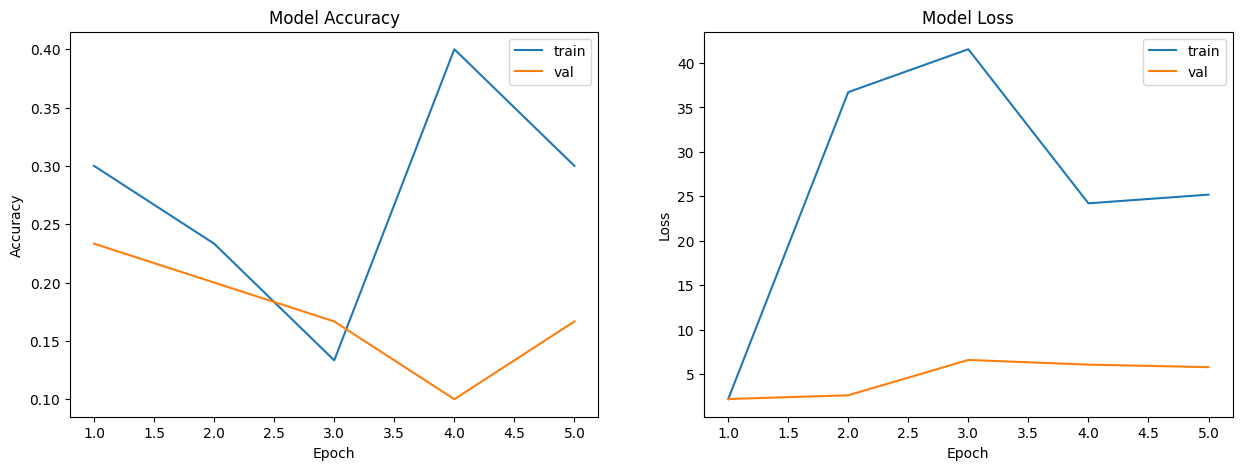

In [16]:
plot_model_history(history)